# Ecological models: relevant?
## NIOZ Master Thesis Project

This Jupyter Notebook contains a detailed description and workflow to train two machine learning models for my thesis. Every section is denoted with a second level heading to keep track of my experiments. First the data from the EBT Tool is imported - a deterministic population model resembling a tri-trophic system in the Baltic Sea (Van Leeuwen et al., 2008). This data is used to train two machine learning models (TCDF and PCMCI respectively) to infer (ecological) causal relations. Both are convolutional machine learning models, and able to handle non-stationary temporal data. 

Author: R. Draaijer

## Enabling notebook to be run on any device

In [1]:
import os

# Create universally (i.e. across various operating systems) recognized paths

notebook_path = os.path.abspath('MSc Thesis 1.ipynb')                  # Jupyter notebook path
TCDF_path = os.path.join(os.path.dirname(notebook_path), 'TCDF')       # TCDF folder path
TCDFdata_path = os.path.join(TCDF_path, 'data')                        # TCDF/data folder path
EBT_path = os.path.join(os.path.dirname(notebook_path), 'EBT Data')    # EBT folder path
DefaultCod_path = os.path.join(EBT_path, 'Modified Default Cod')       # EBT/Modified Default Cod folder path
Cod_path = os.path.join(DefaultCod_path, 'Modified Default.out')       # EBT/Modified Default Cod/Modified Default.out file path

## EBT Tool

### Import EBT Tool Data with NumPy
Two different datasets can be distinguished: Default Cod and Cannibalistic Cod. See paper (2008) and EBT Tutorial (2020) by Anieke van Leeuwen et al.

*Note that objects with uppercase namespaces are solely used for raw data files

In [2]:
# Get path for EBT data (.txt file)
path = Cod_path

# Check first entries of data
with open(path) as Default_Cod:
    print(Default_Cod.readline())

In [3]:
# Convert dataset to ndarray
import numpy as np

with open(path) as Default_Cod:
    default_cod = np.loadtxt(Default_Cod)

# Check (dimensions of) array
print(default_cod) 
print(default_cod.shape)           # Must be identical to ('Maximum integration time' + 1, OUTPUT_VAR_NR + 1) in EBT tool
print(default_cod.dtype)           # Should be float64

[[0.00000000e+00 0.00000000e+00 5.48212970e+01 ... 3.07874116e-01
  9.83841000e+00 0.00000000e+00]
 [1.00000000e+00 2.73972600e-03 5.48213227e+01 ... 3.07874682e-01
  9.83841208e+00 0.00000000e+00]
 [2.00000000e+00 5.47945210e-03 5.48213485e+01 ... 3.07875243e-01
  9.83841413e+00 0.00000000e+00]
 ...
 [3.64980000e+04 9.99945205e+01 6.25598481e+00 ... 2.24811300e-08
  6.26818600e-07 0.00000000e+00]
 [3.64990000e+04 9.99972603e+01 6.25598481e+00 ... 2.24691700e-08
  6.26477700e-07 0.00000000e+00]
 [3.65000000e+04 1.00000000e+02 6.25598481e+00 ... 2.24572100e-08
  6.26137000e-07 0.00000000e+00]]
(36501, 24)
float64


In hindsight the library pandas can be highly useful for loading data, therefore:

### Import EBT Tool Data with pandas
Two different datasets can be distinguished: Default Cod and Cannibalistic Cod. See paper (2008) and EBT Tutorial (2020) by Anieke van Leeuwen et al.

*Note that objects with uppercase namespaces are solely used for raw data files*

In [4]:
import pandas as pd

# Get path for EBT data (.txt file)
path = Cod_path

# Define column names (see EBT .c file in output variables section) for multilevel indexing
variables = ['Time', 'Years', 'RS', 'RJ', 'RA', 'SJ', 'SA', 'SB', 'CJ', 'CA', 'CB', 'Fc', 'ΔCJ with Fc', 'ΔCS with Fc',
             'ΔCA with Fc', 'ΔC with Fc', 'ΔSB', 'ΔSJ', 'ΔSA', 'ΔCB', 'ΔCJ', 'ΔCA', 'ΣC', 'Fs']
units = ['[day]', '[year]', '[g V-1]', '[g V-1]', '[g V-1]', '[g V-1]', '[g V-1]', '[g V-1]', '[g V-1]', '[g V-1]',
         '[g V-1]', '[-]', '[g V-1 year-1]', '[g V-1 year-1]', '[g V-1 year-1]', '[g V-1 year-1]', '[g V-1 year-1]',
         '[g V-1 year-1]', '[g V-1 year-1]', '[g V-1 year-1]', '[g V-1 year-1]', '[g V-1 year-1]', '[g V-1]', '[-]']

with open(path) as Default_Cod:
    default_cod = pd.read_csv(Default_Cod, delimiter = '\t', header=None)

# Set column names and index
#columns = pd.MultiIndex.set_codes([[variables, units]], names = ['Output variable', 'Unit'])
default_cod.columns = variables
#default_cod.columns = columns
default_cod = default_cod.set_index('Time')

# Check (dimensions of) array
print(default_cod.shape)           # Must be identical to ('Maximum integration time' + 1, OUTPUT_VAR_NR + 1) in EBT tool

default_cod.head()

(36501, 23)


,Years,RS,RJ,RA,SJ,SA,SB,CJ,CA,CB,...,ΔCA with Fc,ΔC with Fc,ΔSB,ΔSJ,ΔSA,ΔCB,ΔCJ,ΔCA,ΣC,Fs
Time,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,54.821297,0.268207,0.989287,8.511213,9.955314,50.033894,8.186889,0.809228,0.842293,...,0.0,0.0,56.602835,22.673092,25.988747,0.830739,0.149208,0.307874,9.838410,0.0
1.0,0.002740,54.821323,0.268207,0.989287,8.511207,9.955310,50.033881,8.186888,0.809230,0.842294,...,0.0,0.0,56.602823,22.673058,25.988736,0.830741,0.149204,0.307875,9.838412,0.0
2.0,0.005479,54.821349,0.268207,0.989287,8.511201,9.955306,50.033867,8.186887,0.809231,0.842295,...,0.0,0.0,56.602811,22.673023,25.988726,0.830742,0.149200,0.307875,9.838414,0.0
3.0,0.008219,54.821374,0.268207,0.989287,8.511194,9.955302,50.033854,8.186887,0.809233,0.842297,...,0.0,0.0,56.602799,22.672989,25.988715,0.830743,0.149195,0.307876,9.838416,0.0
4.0,0.010959,54.821401,0.268207,0.989287,8.511188,9.955297,50.033840,8.186886,0.809235,0.842298,...,0.0,0.0,56.602787,22.672955,25.988704,0.830744,0.149191,0.307876,9.838418,0.0


Text(0.5, 0, 'Time [year]')

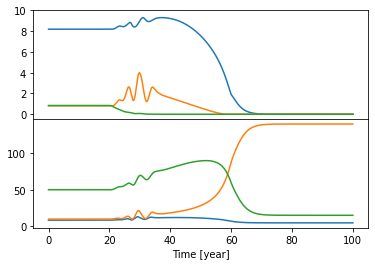

In [5]:
# Visualize default_cod as is visualized by the EBT tool
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Make figure to visualize plots in
fig, axes = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0)

# Select the biomass columns
# Cod biomass
cod_fig = fig.add_subplot(axes[0])
cod_fig.plot(default_cod['Years'], default_cod[['CJ','CA','CB']])

cod_fig.set_xticks(np.arange(0,110,20))
cod_fig.set_yticks(np.arange(0,12,2))


# Sprat biomass
sprat_fig = fig.add_subplot(axes[1])
sprat_fig.plot(default_cod['Years'], default_cod[['SJ','SA','SB']])

cod_fig.set_xticks(np.arange(0,110,20))
cod_fig.set_yticks(np.arange(0,12,2))
sprat_fig.set_xlabel('Time [year]')

## TCDF Demo

This is a short demo for the first machine learning model, to get familiar with the training and testing of data. 

In [6]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

# Load data from EBT tool into DataFrame
path = Cod_path
ebt = pd.read_csv(path, delimiter = '\t', header = None)

# Show first 10 rows of dataset
ebt.head(10)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,0.000000,54.821297,0.268207,0.989287,8.511213,9.955314,50.033894,8.186889,0.809228,...,0.0,0.0,56.602835,22.673092,25.988747,0.830739,0.149208,0.307874,9.838410,0.0
1,1.0,0.002740,54.821323,0.268207,0.989287,8.511207,9.955310,50.033881,8.186888,0.809230,...,0.0,0.0,56.602823,22.673058,25.988736,0.830741,0.149204,0.307875,9.838412,0.0
2,2.0,0.005479,54.821349,0.268207,0.989287,8.511201,9.955306,50.033867,8.186887,0.809231,...,0.0,0.0,56.602811,22.673023,25.988726,0.830742,0.149200,0.307875,9.838414,0.0
3,3.0,0.008219,54.821374,0.268207,0.989287,8.511194,9.955302,50.033854,8.186887,0.809233,...,0.0,0.0,56.602799,22.672989,25.988715,0.830743,0.149195,0.307876,9.838416,0.0
4,4.0,0.010959,54.821401,0.268207,0.989287,8.511188,9.955297,50.033840,8.186886,0.809235,...,0.0,0.0,56.602787,22.672955,25.988704,0.830744,0.149191,0.307876,9.838418,0.0
5,5.0,0.013699,54.821427,0.268207,0.989287,8.511182,9.955293,50.033827,8.186885,0.809236,...,0.0,0.0,56.602775,22.672921,25.988692,0.830745,0.149187,0.307877,9.838420,0.0
6,6.0,0.016438,54.821453,0.268207,0.989287,8.511175,9.955289,50.033813,8.186884,0.809238,...,0.0,0.0,56.602763,22.672887,25.988681,0.830747,0.149183,0.307877,9.838422,0.0
7,7.0,0.019178,54.821479,0.268207,0.989287,8.511169,9.955284,50.033799,8.186883,0.809240,...,0.0,0.0,56.602751,22.672853,25.988669,0.830748,0.149179,0.307878,9.838424,0.0
8,8.0,0.021918,54.821506,0.268206,0.989287,8.511163,9.955279,50.033786,8.186882,0.809241,...,0.0,0.0,56.602739,22.672819,25.988657,0.830749,0.149175,0.307879,9.838426,0.0
9,9.0,0.024658,54.821533,0.268206,0.989287,8.511157,9.955275,50.033772,8.186881,0.809243,...,0.0,0.0,56.602727,22.672785,25.988645,0.830750,0.149171,0.307879,9.838428,0.0


### Data Cleaning

In [7]:
# Rename columns (see file /Users/apple/Desktop/MSc Thesis 1/MSc Thesis/Coding/Explanation Output Parameters.docx)
labels = ['Time (day)', 'Time (year)',                    # Time labels
          'Rs', 'Rj', 'Ra',                               # Shared resources biomass
          'Sj', 'Sa', 'Sb',                               # Sprat stages biomass
          'Cj', 'Ca', 'Cb',                               # Cod stages biomass
          'Fc',                                           # Fishing imposed on cod
          'ΔCj + Fc', 'ΔCa + Fc', 'ΔCb + Fc', 'ΔC + Fc', # Changes in cod biomass when fishing present
          'ΔSb', 'ΔSj', 'ΔSa',                           # Changes in sprat biomass
          'ΔCb', 'ΔCj', 'ΔCa',                           # Changes in cod biomass
          'ΣC',                                           # Sum of cod biomass
          'Fs']                                           # Fishing imposed on sprat
ebt.columns = labels

# Show new column labels
print(ebt.columns)

Index(['Time (day)', 'Time (year)', 'Rs', 'Rj', 'Ra', 'Sj', 'Sa', 'Sb', 'Cj',
       'Ca', 'Cb', 'Fc', 'ΔCj + Fc', 'ΔCa + Fc', 'ΔCb + Fc', 'ΔC + Fc', 'ΔSb',
       'ΔSj', 'ΔSa', 'ΔCb', 'ΔCj', 'ΔCa', 'ΣC', 'Fs'],
      dtype='object')


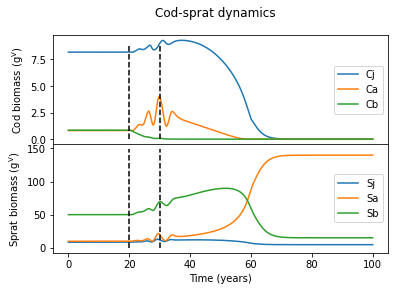

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as lines

# Select data to be visualized
cod = ebt[['Cj', 'Ca', 'Cb']]
sprat = ebt[['Sj', 'Sa', 'Sb']]
time = ebt['Time (year)']

# Set subplot figure defaults
fig, [cod_plt, sprat_plt] = plt.subplots(2, 1, sharex = True)
fig.subplots_adjust(hspace = 0)
fig.suptitle('Cod-sprat dynamics')

# Set labels for shared x-axis and individual y-axes
cod_plt.set(ylabel = 'Cod biomass ($\mathregular{g^V}$)')
sprat_plt.set(ylabel = 'Sprat biomass ($\mathregular{g^V}$)')
plt.xlabel('Time (years)')

# Visualize data
cod_plt.plot(time, cod)
sprat_plt.plot(time, sprat)

# Add legends
cod_plt.legend(['Cj', 'Ca', 'Cb'], loc = 'center right')
sprat_plt.legend(['Sj', 'Sa', 'Sb'], loc = 'center right')

# Draw vertical line at 20 years and 30 years to visualize data selection
cod_plt.plot([20] * 10, np.arange(0,10), '--k')
sprat_plt.plot([20] * 150, np.arange(0,150), '--k')

cod_plt.plot([30] * 10, np.arange(0,10), '--k')
sprat_plt.plot([30] * 150, np.arange(0,150), '--k')

In the above figure dashed lines represent the data I have selected to carry out a demo of the TCDF machine learning model. For the purpose of this demo I have aditionally selected a low resolution of 30 day timesteps over 100 years. Next I will clean the data for this demo purpose too, with the following characteristics:
> - Data between year 20 and 30 (i.e. 120 datapoints) 
> - Inclusion of the columns representing sprat- and cod stages
> - Inclusion of the shared resources columns

The data needs to be converted into a .csv file with every column representative of a (continuous) timeseries and the header needs explanatory column names (for eventually we will create a temporal causal graph with each node representing a timeseries).

In [9]:
# Select information of datapoints between year 20 and 30
demo_ebt = ebt[(ebt['Time (year)'] >= 20) & (ebt['Time (year)'] <= 30)]

# Select only the necessary biomass columns as timeseries
demo_ebt = demo_ebt[['Rs', 'Rj', 'Ra',
                     'Sj', 'Sa', 'Sb',
                     'Cj', 'Ca', 'Cb',
                     'Fc']]

# Reset index
demo_ebt.reset_index(inplace = True)
demo_ebt.drop('index', axis = 'columns', inplace = True)

# Show first and last five columns of clean dataframe
demo_ebt.head(-5)

,Rs,Rj,Ra,Sj,Sa,Sb,Cj,Ca,Cb,Fc
0,54.838332,0.268238,0.989280,8.510205,9.956561,50.013244,8.184919,0.809400,0.843533,0.000000
1,54.838332,0.268238,0.989280,8.510205,9.956561,50.013244,8.184919,0.809399,0.843532,0.001027
2,54.838332,0.268238,0.989280,8.510205,9.956561,50.013244,8.184919,0.809399,0.843530,0.002055
3,54.838332,0.268238,0.989280,8.510205,9.956561,50.013244,8.184918,0.809398,0.843527,0.003082
4,54.838332,0.268238,0.989280,8.510205,9.956561,50.013244,8.184917,0.809396,0.843522,0.004110
...,...,...,...,...,...,...,...,...,...,...
3641,25.940005,0.290546,0.969713,11.992235,20.165629,69.478724,8.987906,3.973822,0.076795,3.740753
3642,25.957505,0.290461,0.969712,11.986605,20.150119,69.483323,8.989210,3.972971,0.076769,3.741781
3643,25.975086,0.290377,0.969711,11.980978,20.134557,69.487854,8.990512,3.972101,0.076743,3.742808
3644,25.992747,0.290292,0.969711,11.975354,20.118942,69.492318,8.991813,3.971212,0.076716,3.743836


### Low Resolution Dataset
Run these cells when performing machine learning model with low res dataset

In [10]:
# Compress dataset to lower resolution (~365 datapoints)
low_demo_ebt = demo_ebt.iloc[::10, :]
low_demo_ebt.reset_index(drop = True, inplace = True)
low_demo_ebt['Time'] = np.linspace(20, 30, 366)

# Check format of low resolution dataset
low_demo_ebt

,Rs,Rj,Ra,Sj,Sa,Sb,Cj,Ca,Cb,Fc,Time
0,54.838332,0.268238,0.989280,8.510205,9.956561,50.013244,8.184919,0.809400,0.843533,0.000000,20.000000
1,54.838330,0.268238,0.989280,8.510207,9.956563,50.013248,8.184903,0.809379,0.843464,0.010274,20.027397
2,54.838303,0.268239,0.989280,8.510224,9.956576,50.013281,8.184851,0.809317,0.843258,0.020548,20.054795
3,54.838202,0.268241,0.989282,8.510272,9.956614,50.013370,8.184762,0.809213,0.842916,0.030822,20.082192
4,54.837966,0.268244,0.989284,8.510369,9.956694,50.013544,8.184634,0.809070,0.842440,0.041096,20.109589
...,...,...,...,...,...,...,...,...,...,...,...
361,25.440350,0.293186,0.969794,12.167928,20.617554,69.302405,8.946928,3.990450,0.077369,3.708904,29.890411
362,25.592090,0.292331,0.969755,12.111058,20.478283,69.366466,8.960258,3.987189,0.077231,3.719178,29.917808
363,25.753000,0.291479,0.969728,12.054347,20.332621,69.423668,8.973486,3.981907,0.077048,3.729452,29.945205
364,25.922587,0.290631,0.969713,11.997868,20.181086,69.474057,8.986601,3.974654,0.076820,3.739726,29.972603


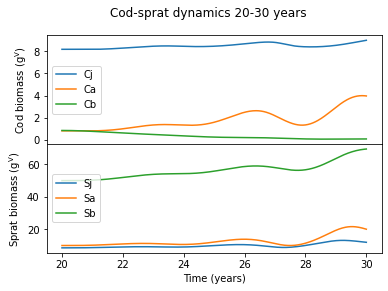

In [11]:
# Visualize data from lower resolution dataset 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as lines

# Select data to be visualized
cod = low_demo_ebt[['Cj', 'Ca', 'Cb']]
sprat = low_demo_ebt[['Sj', 'Sa', 'Sb']]
time = low_demo_ebt['Time']

# Set subplot figure defaults
fig, [cod_plt, sprat_plt] = plt.subplots(2, 1, sharex = True)
fig.subplots_adjust(hspace = 0)
fig.suptitle('Cod-sprat dynamics 20-30 years')

# Set labels for shared x-axis and individual y-axes
cod_plt.set(ylabel = 'Cod biomass ($\mathregular{g^V}$)')
sprat_plt.set(ylabel = 'Sprat biomass ($\mathregular{g^V}$)')
plt.xlabel('Time (years)')

# Visualize data
cod_plt.plot(time, cod)
sprat_plt.plot(time, sprat)

# Add legends
cod_plt.legend(['Cj', 'Ca', 'Cb'], loc = 'center left')
sprat_plt.legend(['Sj', 'Sa', 'Sb'], loc = 'center left')

# Remove Time column
low_demo_ebt.drop(['Time'], axis = 1, inplace = True)

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Normalize data with min-max normalization
scaler = MinMaxScaler()
ebt_scaled = scaler.fit_transform(low_demo_ebt)

# Write scaled data to DataFrame
labels = ['Rs', 'Rj', 'Ra',
          'Sj', 'Sa', 'Sb',
          'Cj', 'Ca', 'Cb',
          'Fc']
demo_ebt_scaled = pd.DataFrame(ebt_scaled, columns = labels)

# Check the scaled DataFrame
demo_ebt_scaled.head(-10)

,Rs,Rj,Ra,Sj,Sa,Sb,Cj,Ca,Cb,Fc
0,1.000000,0.165405,0.984417,0.000000e+00,0.000123,0.000000e+00,0.011209,0.002429,1.000000,0.000000
1,1.000000,0.165409,0.984422,5.055820e-07,0.000123,2.369050e-07,0.011189,0.002423,0.999912,0.002740
2,0.999999,0.165428,0.984450,4.195656e-06,0.000124,1.907222e-06,0.011126,0.002403,0.999650,0.005479
3,0.999996,0.165470,0.984512,1.458505e-05,0.000128,6.462716e-06,0.011018,0.002371,0.999214,0.008219
4,0.999988,0.165540,0.984610,3.547577e-05,0.000135,1.537952e-05,0.010862,0.002326,0.998606,0.010959
...,...,...,...,...,...,...,...,...,...,...
351,0.000394,0.834836,0.058395,9.102274e-01,0.994137,9.365301e-01,0.771108,0.972165,0.021485,0.961644
352,0.001315,0.818991,0.050148,8.991905e-01,0.990120,9.433765e-01,0.787616,0.978138,0.021878,0.964384
353,0.002741,0.802812,0.042518,8.878420e-01,0.985123,9.498690e-01,0.804167,0.983378,0.022219,0.967123
354,0.004649,0.786351,0.035513,8.762325e-01,0.979184,9.560058e-01,0.820744,0.987887,0.022505,0.969863


### High Resolution Dataset
Run these cells when performing machine learning model with high res dataset

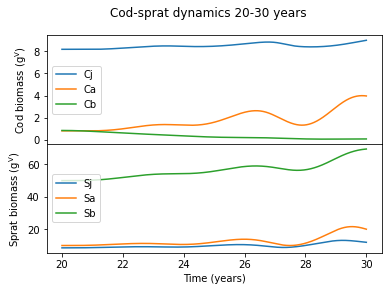

In [13]:
# Visualize data from lower resolution dataset 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as lines

# Select data to be visualized
cod = demo_ebt[['Cj', 'Ca', 'Cb']]
sprat = demo_ebt[['Sj', 'Sa', 'Sb']]
demo_ebt['Time'] = np.linspace(20, 30, 3651)
time = demo_ebt['Time']

# Set subplot figure defaults
fig, [cod_plt, sprat_plt] = plt.subplots(2, 1, sharex = True)
fig.subplots_adjust(hspace = 0)
fig.suptitle('Cod-sprat dynamics 20-30 years')

# Set labels for shared x-axis and individual y-axes
cod_plt.set(ylabel = 'Cod biomass ($\mathregular{g^V}$)')
sprat_plt.set(ylabel = 'Sprat biomass ($\mathregular{g^V}$)')
plt.xlabel('Time (years)')

# Visualize data
cod_plt.plot(time, cod)
sprat_plt.plot(time, sprat)

# Add legends
cod_plt.legend(['Cj', 'Ca', 'Cb'], loc = 'center left')
sprat_plt.legend(['Sj', 'Sa', 'Sb'], loc = 'center left')

# Remove Time column
demo_ebt.drop(['Time'], axis = 1, inplace = True)

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Normalize data with min-max normalization
scaler = MinMaxScaler()
ebt_scaled = scaler.fit_transform(demo_ebt)

# Write scaled data to DataFrame
labels = ['Rs', 'Rj', 'Ra',
          'Sj', 'Sa', 'Sb',
          'Cj', 'Ca', 'Cb',
          'Fc']
demo_ebt_scaled = pd.DataFrame(ebt_scaled, columns = labels)

# Check the scaled DataFrame
demo_ebt_scaled.head(-10)

,Rs,Rj,Ra,Sj,Sa,Sb,Cj,Ca,Cb,Fc
0,1.000000,0.165474,0.984412,0.000000e+00,0.000190,0.000000e+00,0.011218,0.002431,1.000000,0.000000
1,1.000000,0.165474,0.984412,3.460767e-10,0.000190,1.384297e-10,0.011218,0.002431,0.999999,0.000274
2,1.000000,0.165474,0.984412,3.655434e-09,0.000190,1.697049e-09,0.011217,0.002431,0.999996,0.000548
3,1.000000,0.165474,0.984412,1.286972e-08,0.000190,6.111426e-09,0.011216,0.002430,0.999992,0.000822
4,1.000000,0.165474,0.984413,3.110363e-08,0.000190,1.480175e-08,0.011215,0.002430,0.999986,0.001096
...,...,...,...,...,...,...,...,...,...,...
3636,0.043359,0.622474,0.000372,7.592537e-01,0.882482,9.967713e-01,0.977885,0.995656,0.022334,0.996164
3637,0.043923,0.620770,0.000308,7.580328e-01,0.881175,9.970244e-01,0.979474,0.995420,0.022304,0.996438
3638,0.044489,0.619066,0.000250,7.568126e-01,0.879863,9.972741e-01,0.981062,0.995177,0.022273,0.996712
3639,0.045059,0.617363,0.000198,7.555930e-01,0.878546,9.975202e-01,0.982649,0.994929,0.022242,0.996986


### Continue here after selection of dataset resolution

In [15]:
# Define function for visualisation of scaled data 

def visualise_scaled(ebt_scaled, years):
    # Select data to be visualized
    cod = ebt_scaled[['Cj', 'Ca', 'Cb']]
    sprat = ebt_scaled[['Sj', 'Sa', 'Sb']]
    resource = ebt_scaled[['Rj', 'Rs', 'Ra']]
    ebt_scaled['Time'] = np.linspace(years[0], years[1], len(ebt_scaled))
    time = ebt_scaled['Time']

    # Set subplot figure defaults
    fig, [cod_plt, sprat_plt, resource_plt] = plt.subplots(3, 1, sharex = True)
    fig.subplots_adjust(hspace = 0)
    fig.suptitle('Cod-sprat-resource dynamics {start}-{stop} years (scaled min-max)'.format(start=years[0],stop=years[1]))

    # Set labels for shared x-axis and individual y-axes
    cod_plt.set(ylabel = 'Cod biomass')
    sprat_plt.set(ylabel = 'Sprat biomass')
    resource_plt.set(ylabel = 'Resource biomass')
    plt.xlabel('Time (years)')

    # Visualize data
    cod_plt.plot(time, cod)
    sprat_plt.plot(time, sprat)
    resource_plt.plot(time, resource)

    # Add legends
    cod_plt.legend(['Cj', 'Ca', 'Cb'], loc = 'center left')
    sprat_plt.legend(['Sj', 'Sa', 'Sb'], loc = 'center left')
    resource_plt.legend(['Rj', 'Rs', 'Ra'], loc = 'center left')

    # Remove Time column
    ebt_scaled.drop(['Time'], axis = 1, inplace = True)

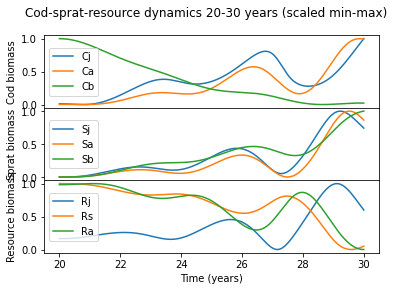

In [16]:
# Visualize scaled data 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as lines

# Plot scaled data 
visualise_scaled(demo_ebt_scaled, [20,30])

In [17]:
# Create file path for new file
DemoEBTScaled_path = os.path.join(TCDFdata_path, 'EBT_demo_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
demo_ebt_scaled.to_csv(DemoEBTScaled_path, index = False)

For implementation of the first machine model (i.e. TCDF) we have to create a reference to the 'groundtruth' of the model. This makes it possible to compare the found relations by the model to the true relations we have defined in the dataset.

The groundtruth file needs to be .csv file, have no heading and contains three columns. The first column consists of the index of the cause (corresponds to the columnnumber in the EBT_demo_dataset.csv file), index of effect (idem dito), and time delay between index and cause.

For the corresponding causes and effects see the paper by A. van Leeuwen et al. (2008).

In [18]:
# Create list of lists for the rows to the groundtruth.csv file
groundtruth_rows = [[9, 7, 0],  # Fc - Ca
                    [9, 8, 0],  # Fc - Cb
                    [6, 1, 0],  # Cj - Rj
                    [6, 3, 0],  # Cj - Sj
                    [7, 3, 0],  # Ca - Sj
                    [7, 4, 0],  # Ca - Sa
                    [7, 5, 0],  # Ca - Sb
                    [8, 3, 0],  # Cb - Sj
                    [8, 4, 0],  # Cb - Sa
                    [8, 5, 0],  # Cb - Sb
                    [8, 2, 0],  # Cb - Ra
                    [3, 0, 0],  # Sj - Rs
                    [4, 0, 0],  # Sa - Rs
                    [5, 0, 0]]  # Sb - Rs

# Convert list into DataFrame
groundtruth = pd.DataFrame(groundtruth_rows)

# Create file path for new file
DemoEBTGroundtruth_path = os.path.join(TCDFdata_path, 'EBT_demo_groundtruth.csv')

# Write DataFrame to .csv
groundtruth.to_csv(DemoEBTGroundtruth_path, index = False, header = False)


Performing the TCDF requires a different directory (where the TCDF is located). Check if the current directory is set at `'/.../TCDF'`.

In [19]:
# Define needed directory
directory = TCDF_path

# Check current working directory
current_directory = os.getcwd()

# Change working directory to perform TCDF
if current_directory != directory:
    os.chdir(TCDF_path)

# Check new current working directory
os.getcwd()

'/Users/apple/Desktop/MSc Thesis 1/MSc Thesis/Coding/GitHub/thesis/TCDF'

This part shows the functionality of TCDF.

See the corresponding paper for more detail: ["Causal Discovery with Attention-Based Convolutional Neural Networks"](https://www.mdpi.com/2504-4990/1/1/19).

In [20]:
# Install conda- and pip packages in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} git
!{sys.executable} -m pip install torchvision

Solving environment: done

# All requested packages already installed.



# TCDF

These next code cells perform the analysis of the (demo) dataset with the TCDF. In the utils.py file you are able to adjust parameters for adaptive learning rate and early stopping. These parameters include type of optimizer (specified in runTCDF.py arguments), number of epochs before adapting learning rate, minimum learning rate, and size of decreasing learning rate factor. For early stopping two parameters are given, the number of epochs before stopping when loss is not improving and the minimum difference in loss improvement.

In [21]:
# Show all argument options

%run -i "runTCDF.py" --help

usage: runTCDF.py [-h] [--cuda] [--epochs EPOCHS] [--kernel_size KERNEL_SIZE]
                  [--hidden_layers HIDDEN_LAYERS]
                  [--learning_rate LEARNING_RATE] [--optimizer {Adam,RMSprop}]
                  [--log_interval LOG_INTERVAL] [--seed SEED]
                  [--dilation_coefficient DILATION_COEFFICIENT]
                  [--significance SIGNIFICANCE] [--plot]
                  (--ground_truth GROUND_TRUTH | --data DATA [DATA ...])
                  [--lr_scheduler] [--early_stopping]

TCDF: Temporal Causal Discovery Framework

optional arguments:
  -h, --help            show this help message and exit
  --cuda                Use CUDA (GPU) (default: False)
  --epochs EPOCHS       Number of epochs (default: 1000)
  --kernel_size KERNEL_SIZE
                        Size of kernel, i.e. window size. Maximum delay to be
                        found is kernel size - 1. Recommended to be equal to
                        dilation coeffient (default: 4)
  --hidden_

<Figure size 432x288 with 0 Axes>

### Function for plotting

In [22]:
# This function is to be used to plot the model's loss or accuracy (i.e. performance) after running 
def plot_performance(losses_or_accuracy):
    """Plots the losses for each trained variable for the TCDF model.
    Takes a dictionary with either losses or accuracy for each variable as input"""
    # Preallocate plots in subplots
    fig, axs = plt.subplots(3, 3, sharex = True)
    for ax in axs.flat:
        ax.set(xlabel='Epochs', ylabel='Performance measure')

    # Iterate over each key in dictionary
    keys = list(losses_or_accuracy.keys())
    
    # Plot every variable in different subplot
    axs[0, 0].plot(np.arange(len(losses_or_accuracy[keys[0]])), losses_or_accuracy[keys[0]])
    axs[0, 0].set_title('Performance Rs')
    axs[0, 1].plot(np.arange(len(losses_or_accuracy[keys[1]])), losses_or_accuracy[keys[1]])
    axs[0, 1].set_title('Performance Rj')
    axs[0, 2].plot(np.arange(len(losses_or_accuracy[keys[2]])), losses_or_accuracy[keys[2]])
    axs[0, 2].set_title('Performance Ra')
    axs[1, 0].plot(np.arange(len(losses_or_accuracy[keys[3]])), losses_or_accuracy[keys[3]])
    axs[1, 0].set_title('Performance Sj')
    axs[1, 1].plot(np.arange(len(losses_or_accuracy[keys[4]])), losses_or_accuracy[keys[4]])
    axs[1, 1].set_title('Performance Sa')
    axs[1, 2].plot(np.arange(len(losses_or_accuracy[keys[5]])), losses_or_accuracy[keys[5]])
    axs[1, 2].set_title('Performance Sb')
    axs[2, 0].plot(np.arange(len(losses_or_accuracy[keys[6]])), losses_or_accuracy[keys[6]])
    axs[2, 0].set_title('Performance Cj')
    axs[2, 1].plot(np.arange(len(losses_or_accuracy[keys[7]])), losses_or_accuracy[keys[7]])
    axs[2, 1].set_title('Performance Ca')
    axs[2, 2].plot(np.arange(len(losses_or_accuracy[keys[8]])), losses_or_accuracy[keys[8]])
    axs[2, 2].set_title('Performance Cb')


## TCDF Training

In this section I will tweak (hyper)parameters and save the best outcomes thus far. After implementation of a learning rate scheduler and early stopping to help the process of training the model (see the ~.py files in the TCDF folder, any adjustments are highlighted by '# Adjusted implementation by Draaijer, R.'). Besides, I have also implemented some extra code to save predictive accuracy of the model to plot the performance of the model after the run. Each run is accompanied by two plots (losses and accuracy) to keep track of training the model. 

### TCDF with EBT demo data
#### TCDF: first run

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=1000, ground_truth={'data/EBT_demo_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, significance=0.95)

 Dataset:  EBT_demo_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.315483
Epoch    32: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [25%] 	Loss: 0.001292
Epoch: 500 [50%] 	Loss: 0.000129
Epoch: 750 [75%] 	Loss: 0.000053
Epoch: 1000 [100%] 	Loss: 0.000042
Potential causes:  [4, 2]
Validated causes:  [4]

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.088744
Epoch    34: reducing learning rate of group 0 to 1.0000e-02.
Epoch    45: reducing learning rate of group 0 t

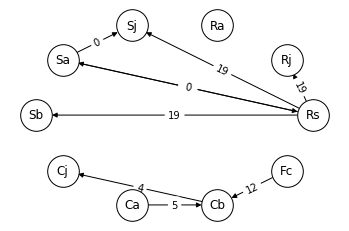

<Figure size 432x288 with 0 Axes>

In [28]:
%matplotlib inline

# Run TCDF with the selected demo dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_demo_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 1000 --log_interval 250 --significance 0.95 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot

#### TCDF: second run (1 extra hidden layer; dilation coefficient and kernel size incremented with 1)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=1000, ground_truth={'data/EBT_demo_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, significance=0.9)

 Dataset:  EBT_demo_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.944516
Epoch    32: reducing learning rate of group 0 to 1.0000e-02.
Epoch    43: reducing learning rate of group 0 to 1.0000e-03.
Epoch    54: reducing learning rate of group 0 to 1.0000e-04.
Epoch    65: reducing learning rate of group 0 to 1.0000e-05.
Epoch    76: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [25%] 	Loss: 0.004019
Epoch: 500 [50%] 	Loss: 0.004012
INFO: Early stopping at epoch 500
Potential causes:  [4]
Validated causes:  []

 Analysis started for target:  Rj
INFO: Ini

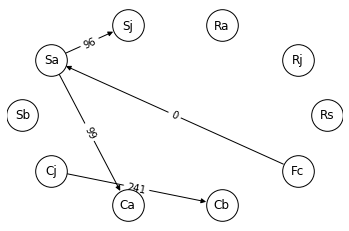

<Figure size 432x288 with 0 Axes>

In [35]:
%matplotlib inline

# Run TCDF with the selected demo dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_demo_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot

#### TCDF: third run (kernel size & dilation coefficient decreased with 1)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=1000, ground_truth={'data/EBT_demo_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, significance=0.9)

 Dataset:  EBT_demo_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.236470
Epoch    18: reducing learning rate of group 0 to 1.0000e-02.
Epoch    87: reducing learning rate of group 0 to 1.0000e-03.
Epoch    98: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 250 [25%] 	Loss: 0.005152
Epoch: 500 [50%] 	Loss: 0.004916
Epoch: 750 [75%] 	Loss: 0.004668
Epoch: 1000 [100%] 	Loss: 0.004433
Potential causes:  [3, 6]
Validated causes:  [3]

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Lo

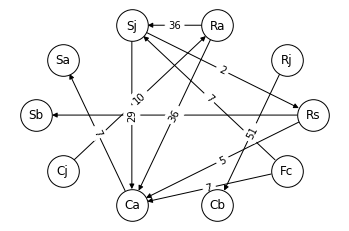

<Figure size 432x288 with 0 Axes>

In [33]:
%matplotlib inline

# Run TCDF with the selected demo dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_demo_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot

Arguments: Namespace(cuda=False, data=['data/EBT_demo_dataset.csv'], dilation_coefficient=3, early_stopping=True, epochs=1000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, train_test_split=0.8)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.281191
Epoch   192: reducing learning rate of group 0 to 1.0000e-02.
Epoch   203: reducing learning rate of group 0 to 1.0000e-03.
Epoch   222: reducing learning rate of group 0 to 1.0000e-04.
Epoch   233: reducing learning rate of group 0 to 1.0000e-05.
Epoch   244: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [25%] 	Loss: 0.000036
Epoch: 500 [50%] 	Loss: 0.000036
INFO: Early stopping at epoch 500

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.014507
Epoch    28: reducing learn

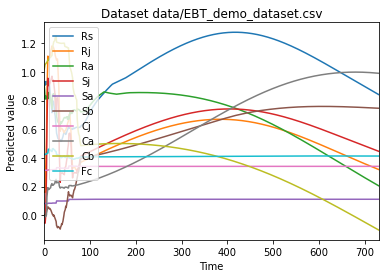

<Figure size 432x288 with 0 Axes>

In [36]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_demo_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot

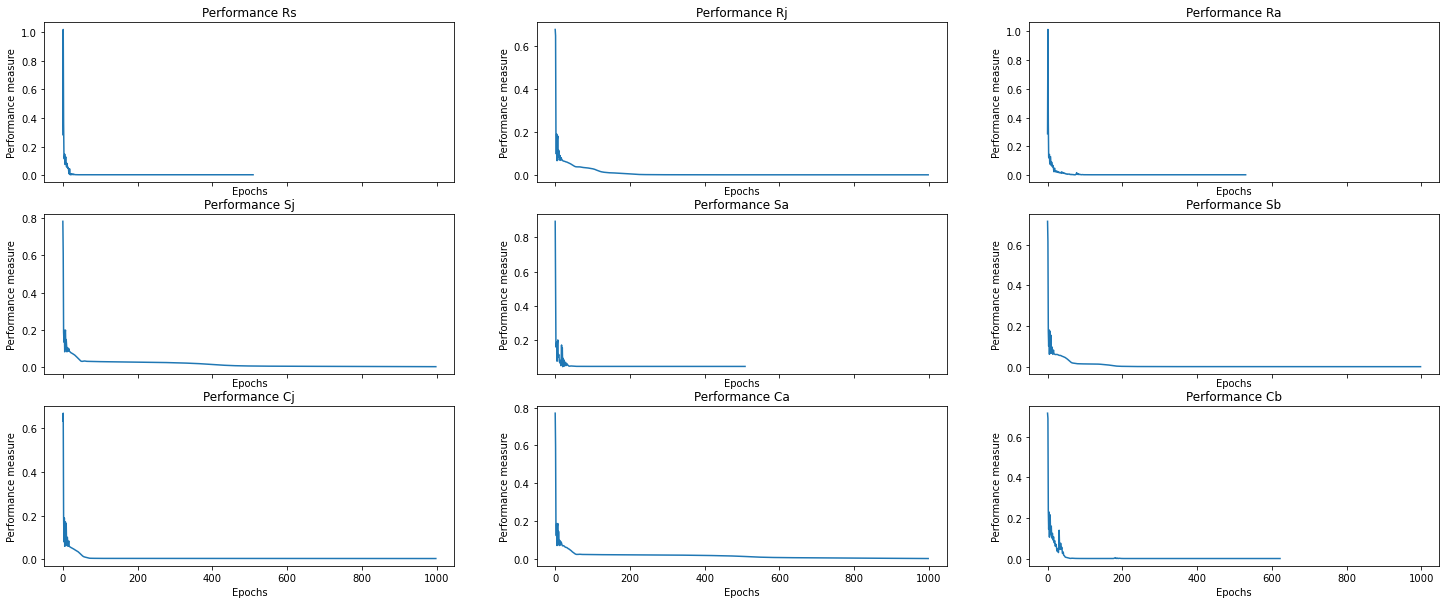

In [37]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

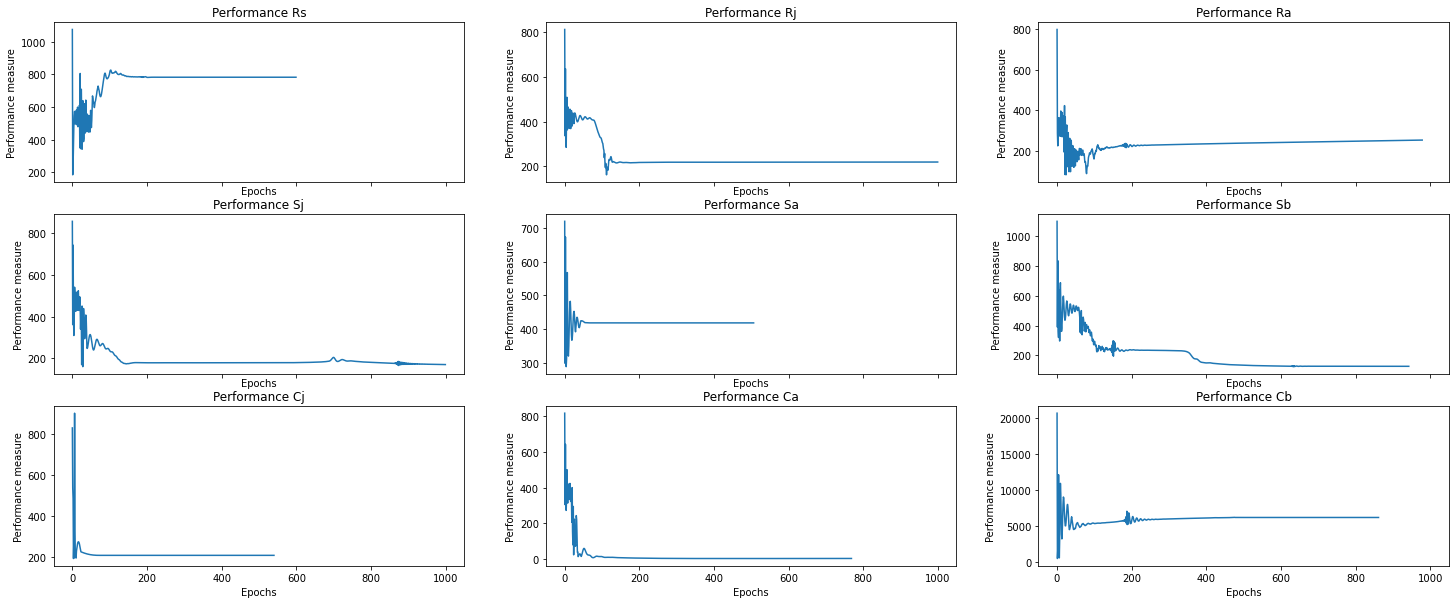

In [38]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF: fourth run (different seed)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=1000, ground_truth={'data/EBT_demo_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=500, lr_scheduler=True, optimizer='Adam', plot=True, seed=1111, significance=0.9)

 Dataset:  EBT_demo_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.775858
Epoch    38: reducing learning rate of group 0 to 1.0000e-02.
Epoch    49: reducing learning rate of group 0 to 1.0000e-03.
Epoch    60: reducing learning rate of group 0 to 1.0000e-04.
Epoch    71: reducing learning rate of group 0 to 1.0000e-05.
Epoch    82: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 500 [50%] 	Loss: 0.050618
INFO: Early stopping at epoch 500
Potential causes:  [5, 8]
Validated causes:  []

 Analysis started for target:  Rj
INFO: Initializing learning rate schedu

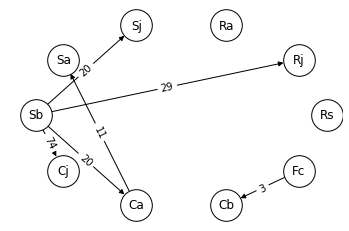

<Figure size 432x288 with 0 Axes>

In [39]:
%matplotlib inline

# Run TCDF and evaluate by comparing the results to the ground truth

%run -i "runTCDF.py"  --ground_truth data/EBT_demo_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot

Arguments: Namespace(cuda=False, data=['data/EBT_demo_dataset.csv'], dilation_coefficient=3, early_stopping=True, epochs=1000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=500, lr_scheduler=True, optimizer='Adam', plot=True, seed=1111, train_test_split=0.8)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.919129
Epoch    19: reducing learning rate of group 0 to 1.0000e-02.
Epoch   457: reducing learning rate of group 0 to 1.0000e-03.
Epoch   477: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 500 [50%] 	Loss: 0.000045
Epoch   500: reducing learning rate of group 0 to 1.0000e-05.
Epoch   511: reducing learning rate of group 0 to 1.0000e-06.
INFO: Early stopping at epoch 500

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.160017
Epoch    29: reducing learning rate of group 0 to 1.0000e-02

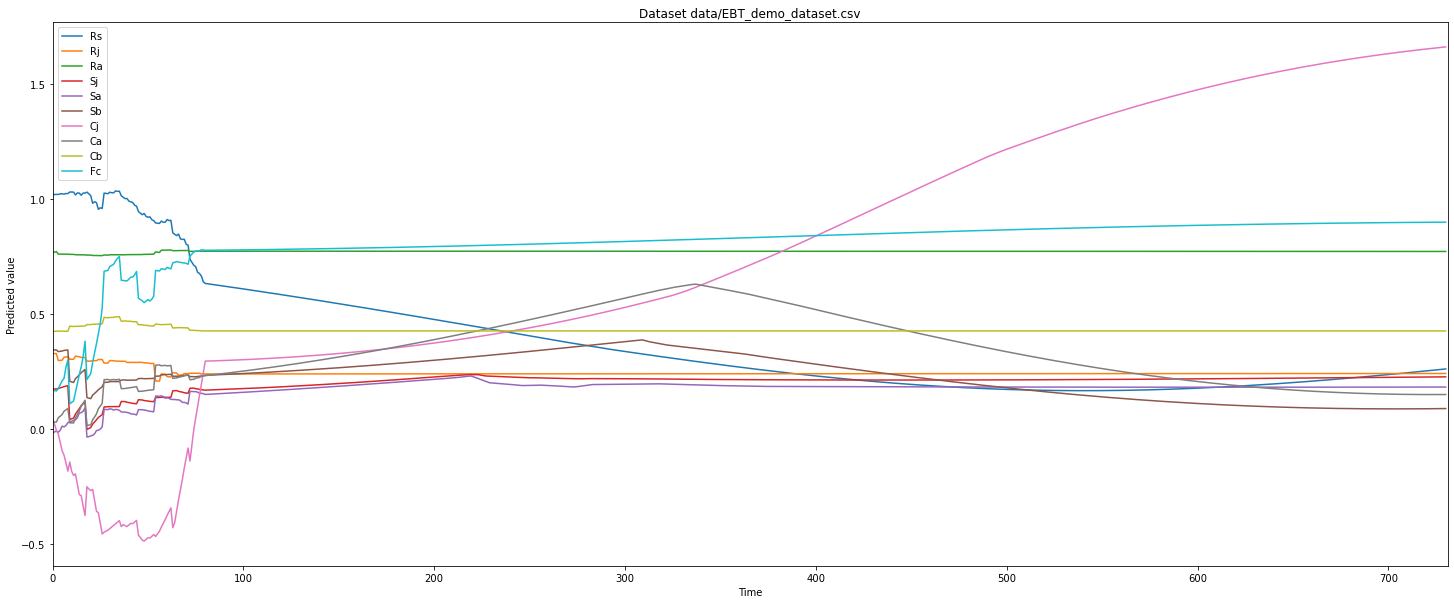

<Figure size 1800x720 with 0 Axes>

In [51]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_demo_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.8

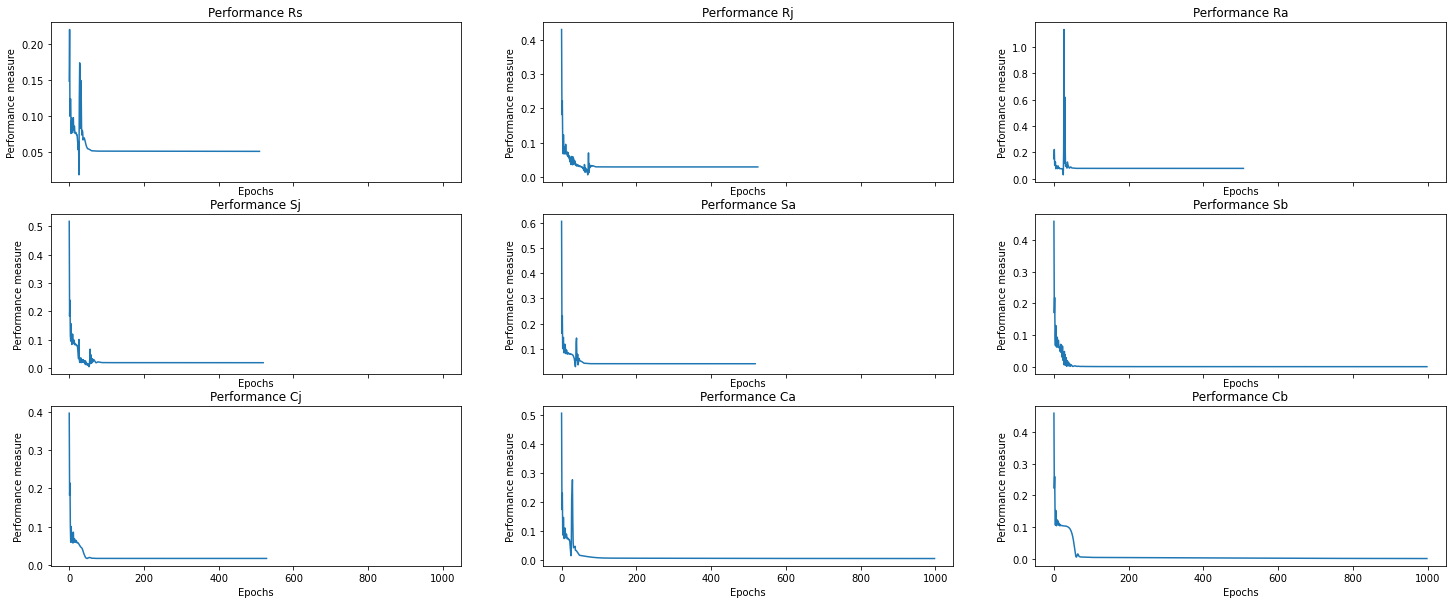

In [41]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

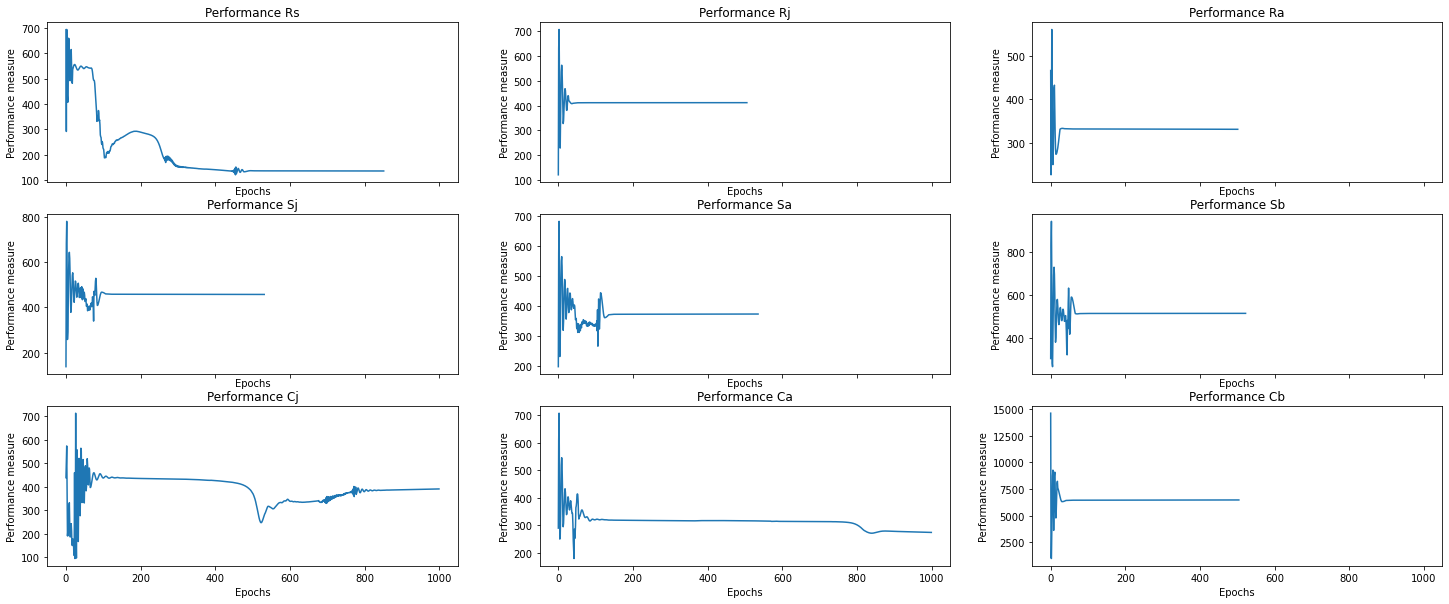

In [42]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF: fourth run (different seed)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=1000, ground_truth={'data/EBT_demo_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=25942, significance=0.9)

 Dataset:  EBT_demo_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.618979
Epoch    27: reducing learning rate of group 0 to 1.0000e-02.
Epoch    38: reducing learning rate of group 0 to 1.0000e-03.
Epoch    49: reducing learning rate of group 0 to 1.0000e-04.
Epoch    60: reducing learning rate of group 0 to 1.0000e-05.
Epoch    71: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [25%] 	Loss: 0.075373
Epoch: 500 [50%] 	Loss: 0.075359
INFO: Early stopping at epoch 500
Potential causes:  [0, 9, 6, 7]
Validated causes:  []

 Analysis started for target:  Rj

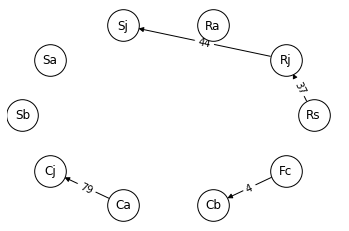

<Figure size 432x288 with 0 Axes>

In [52]:
%matplotlib inline

# Run TCDF and evaluate by comparing the results to the ground truth

%run -i "runTCDF.py"  --ground_truth data/EBT_demo_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 25942 --plot

Arguments: Namespace(cuda=False, data=['data/EBT_demo_dataset.csv'], dilation_coefficient=3, early_stopping=True, epochs=1000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=25942, train_test_split=0.8)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.739712
Epoch    24: reducing learning rate of group 0 to 1.0000e-02.
Epoch    35: reducing learning rate of group 0 to 1.0000e-03.
Epoch    46: reducing learning rate of group 0 to 1.0000e-04.
Epoch    57: reducing learning rate of group 0 to 1.0000e-05.
Epoch    68: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [25%] 	Loss: 0.020576
Epoch: 500 [50%] 	Loss: 0.020284
INFO: Early stopping at epoch 500

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.093206
Epoch    18: reducing lear

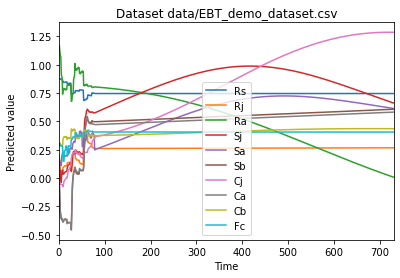

<Figure size 432x288 with 0 Axes>

In [53]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_demo_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 25942 --plot --train_test_split 0.8

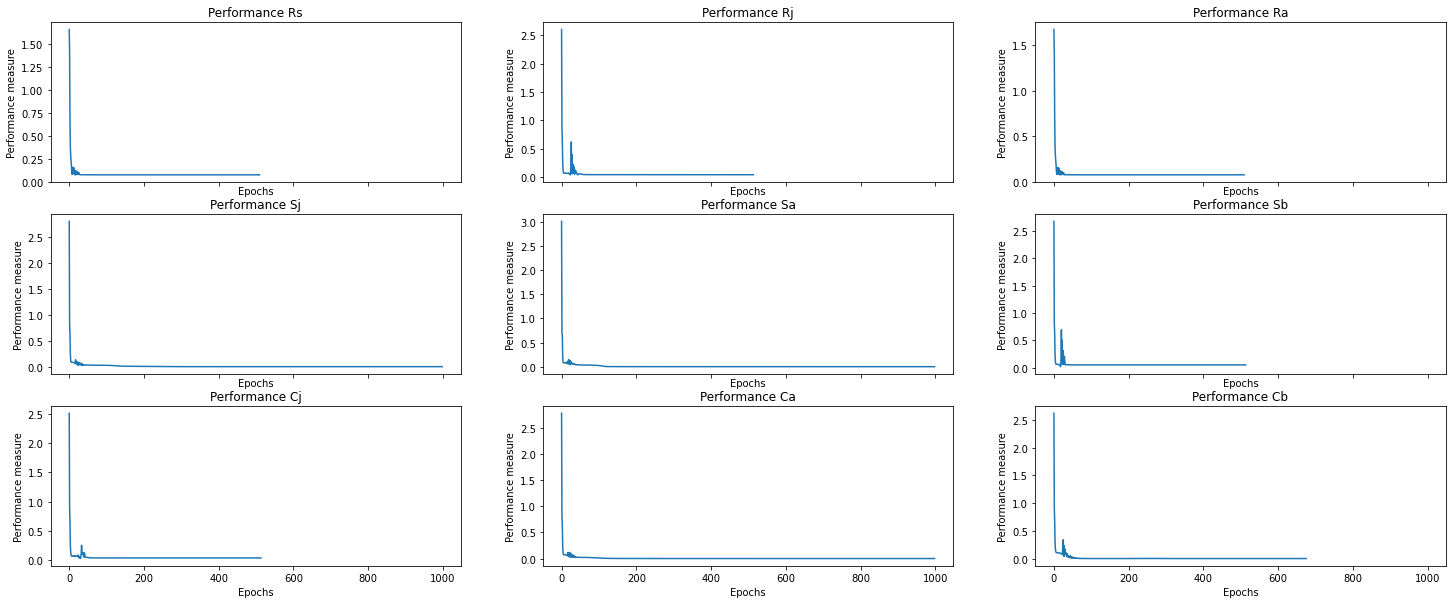

In [54]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

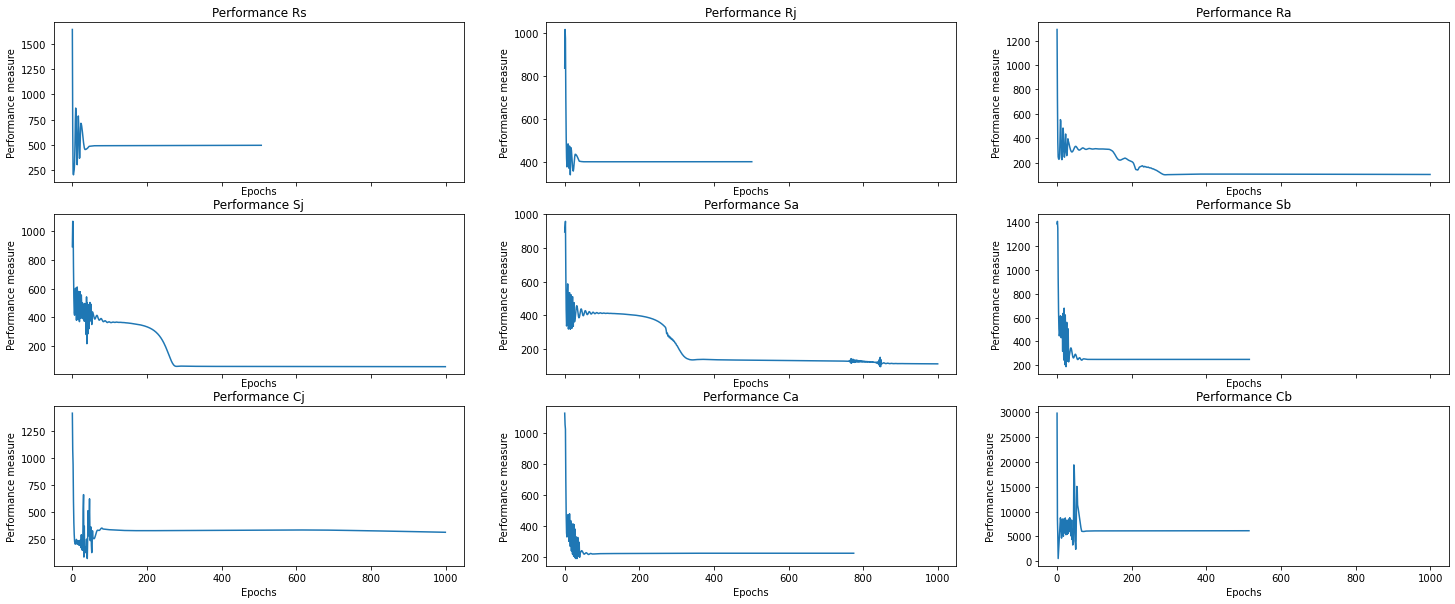

In [55]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

There seems to be big differences in performance and loss when changing the seed, this indicates an unstable pattern and have to find better (hyper)parameters. Or maybe because there is too little data for now?

### TCDF with EBT total dynamics

This data represents the tritrophic biomasses including the total dynamics (shift change). The system first is at its equilibrium and remains stable for ~20 years, fishing pressure is introduced and a new equilibrium is to be found (at 70 years it is stable again). Data is split into two 'total dynamics', 0 - 100 years and 20 - 70 years respectively.

#### Data cleaning

In [56]:
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML

# Select information of datapoints between year 20 and 70
total_ebt = ebt[(ebt['Time (year)'] >= 20) & (ebt['Time (year)'] <= 70)]
total_ebt_2 = ebt[(ebt['Time (year)'] >= 0) & (ebt['Time (year)'] <= 100)]


# Normalize data with min-max normalization
scaler = MinMaxScaler()
ebt_scaled_1 = scaler.fit_transform(total_ebt[['Rs', 'Rj', 'Ra',
                                             'Sj', 'Sa', 'Sb',
                                             'Cj', 'Ca', 'Cb',
                                             'Fc']])
ebt_scaled_2 = scaler.fit_transform(total_ebt_2[['Rs', 'Rj', 'Ra',
                                             'Sj', 'Sa', 'Sb',
                                             'Cj', 'Ca', 'Cb',
                                             'Fc']])

# Write scaled data to DataFrame
labels = ['Rs', 'Rj', 'Ra',
          'Sj', 'Sa', 'Sb',
          'Cj', 'Ca', 'Cb',
          'Fc']
ebt_scaled_1 = pd.DataFrame(ebt_scaled_1, columns = labels)
ebt_scaled_2 = pd.DataFrame(ebt_scaled_2, columns = labels)

# Check the scaled DataFrame
display(ebt_scaled_1.head(-10))
display(ebt_scaled_2.head(-10))

,Rs,Rj,Ra,Sj,Sa,Sb,Cj,Ca,Cb,Fc
0,1.00000,0.018127,0.646078,0.441177,0.000017,0.459337,0.879586,2.027708e-01,1.000000,0.000000
1,1.00000,0.018127,0.646078,0.441177,0.000017,0.459337,0.879586,2.027707e-01,0.999999,0.000068
2,1.00000,0.018127,0.646078,0.441177,0.000017,0.459337,0.879586,2.027705e-01,0.999997,0.000137
3,1.00000,0.018127,0.646079,0.441177,0.000017,0.459337,0.879586,2.027703e-01,0.999993,0.000205
4,1.00000,0.018127,0.646079,0.441177,0.000017,0.459337,0.879586,2.027699e-01,0.999987,0.000274
...,...,...,...,...,...,...,...,...,...,...
18236,0.00003,0.999801,0.999999,0.000081,0.999837,0.000260,0.000056,3.579564e-07,0.000043,0.000000
18237,0.00003,0.999815,0.999999,0.000075,0.999849,0.000241,0.000052,3.559397e-07,0.000043,0.000000
18238,0.00003,0.999829,0.999999,0.000069,0.999861,0.000222,0.000048,3.539230e-07,0.000043,0.000000
18239,0.00003,0.999844,0.999999,0.000063,0.999872,0.000204,0.000044,3.519088e-07,0.000043,0.000000


,Rs,Rj,Ra,Sj,Sa,Sb,Cj,Ca,Cb,Fc
0,0.999640,0.017874,0.646314,4.437391e-01,0.000014,4.672258e-01,8.801519e-01,2.027305e-01,9.985097e-01,0.0
1,0.999641,0.017874,0.646314,4.437384e-01,0.000014,4.672257e-01,8.801518e-01,2.027309e-01,9.985112e-01,0.0
2,0.999642,0.017874,0.646314,4.437376e-01,0.000014,4.672255e-01,8.801517e-01,2.027313e-01,9.985126e-01,0.0
3,0.999642,0.017873,0.646313,4.437369e-01,0.000014,4.672253e-01,8.801516e-01,2.027317e-01,9.985140e-01,0.0
4,0.999643,0.017873,0.646313,4.437361e-01,0.000014,4.672251e-01,8.801515e-01,2.027321e-01,9.985154e-01,0.0
...,...,...,...,...,...,...,...,...,...,...
36486,0.000066,1.000000,1.000000,4.452738e-10,1.000000,9.053616e-10,3.735778e-10,8.290317e-11,1.568844e-07,0.0
36487,0.000066,1.000000,1.000000,4.091706e-10,1.000000,8.397362e-10,3.467977e-10,7.696076e-11,1.568010e-07,0.0
36488,0.000066,1.000000,1.000000,3.730672e-10,1.000000,7.754502e-10,3.200283e-10,7.102085e-11,1.567177e-07,0.0
36489,0.000066,1.000000,1.000000,3.489984e-10,1.000000,7.098249e-10,2.932697e-10,6.508596e-11,1.566344e-07,0.0


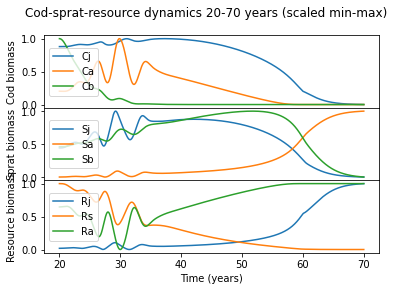

In [57]:
# Visualize scaled data 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as lines

# Plot scaled data 
visualise_scaled(ebt_scaled_1, [20,70])

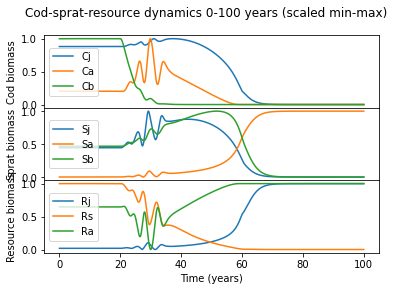

In [58]:
# Visualize scaled data 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as lines

# Plot scaled data 
visualise_scaled(ebt_scaled_2, [0,100])

In [59]:
# Create file path for new file
EBTScaled_path_1 = os.path.join(TCDFdata_path, 'EBT_20_70_dataset.csv')
EBTScaled_path_2 = os.path.join(TCDFdata_path, 'EBT_0_100_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_scaled_1.to_csv(EBTScaled_path_1, index = False)
ebt_scaled_2.to_csv(EBTScaled_path_2, index = False)

#### TCDF 20-70 years: first run (in triplicate)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=1000, ground_truth={'data/EBT_20_70_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, significance=0.9)

 Dataset:  EBT_20_70_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.097749
Epoch    17: reducing learning rate of group 0 to 1.0000e-02.
Epoch    38: reducing learning rate of group 0 to 1.0000e-03.
Epoch    49: reducing learning rate of group 0 to 1.0000e-04.
Epoch    60: reducing learning rate of group 0 to 1.0000e-05.
Epoch    71: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [25%] 	Loss: 0.101089
Epoch: 500 [50%] 	Loss: 0.100987
INFO: Early stopping at epoch 500
Potential causes:  [2, 3]
Validated causes:  [2, 3]

 Analysis started for target:  Rj


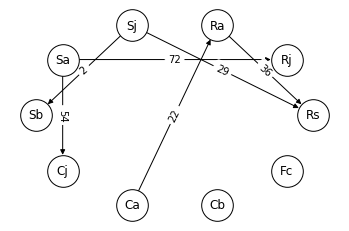

<Figure size 432x288 with 0 Axes>

In [60]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot


Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=1000, ground_truth={'data/EBT_20_70_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=2371, significance=0.9)

 Dataset:  EBT_20_70_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.110100
Epoch    13: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [25%] 	Loss: 0.005852
Epoch   356: reducing learning rate of group 0 to 1.0000e-03.
Epoch   376: reducing learning rate of group 0 to 1.0000e-04.
Epoch   399: reducing learning rate of group 0 to 1.0000e-05.
Epoch   410: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 500 [50%] 	Loss: 0.005628
Epoch: 750 [75%] 	Loss: 0.005627
INFO: Early stopping at epoch 500
Potential causes:  [8, 2, 6]
Validated causes:  [8, 6]

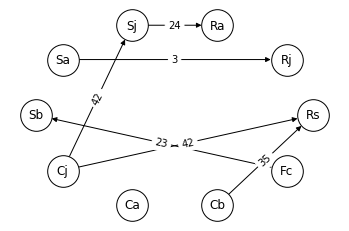

<Figure size 432x288 with 0 Axes>

In [61]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot


Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=1000, ground_truth={'data/EBT_20_70_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=1084, significance=0.9)

 Dataset:  EBT_20_70_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.387469
Epoch    18: reducing learning rate of group 0 to 1.0000e-02.
Epoch    29: reducing learning rate of group 0 to 1.0000e-03.
Epoch    40: reducing learning rate of group 0 to 1.0000e-04.
Epoch    51: reducing learning rate of group 0 to 1.0000e-05.
Epoch    62: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [25%] 	Loss: 0.097886
Epoch: 500 [50%] 	Loss: 0.097870
INFO: Early stopping at epoch 500
Potential causes:  [9, 7]
Validated causes:  []

 Analysis started for target:  Rj
INFO

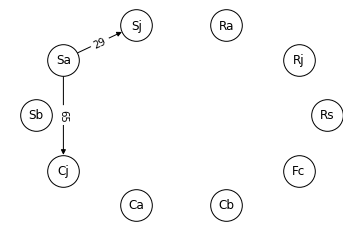

<Figure size 432x288 with 0 Axes>

In [62]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084 --plot


Arguments: Namespace(cuda=False, data=['data/EBT_20_70_dataset.csv'], dilation_coefficient=3, early_stopping=True, epochs=1000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, train_test_split=0.5)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.135261
Epoch    16: reducing learning rate of group 0 to 1.0000e-02.
Epoch   185: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 250 [25%] 	Loss: 0.005050
Epoch: 500 [50%] 	Loss: 0.004590
Epoch: 750 [75%] 	Loss: 0.004215
Epoch: 1000 [100%] 	Loss: 0.003936

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.058924
Epoch    32: reducing learning rate of group 0 to 1.0000e-02.
Epoch    47: reducing learning rate of group 0 to 1.0000e-03.
Epoch    59: reducing learning rate of group 0 to 1.00

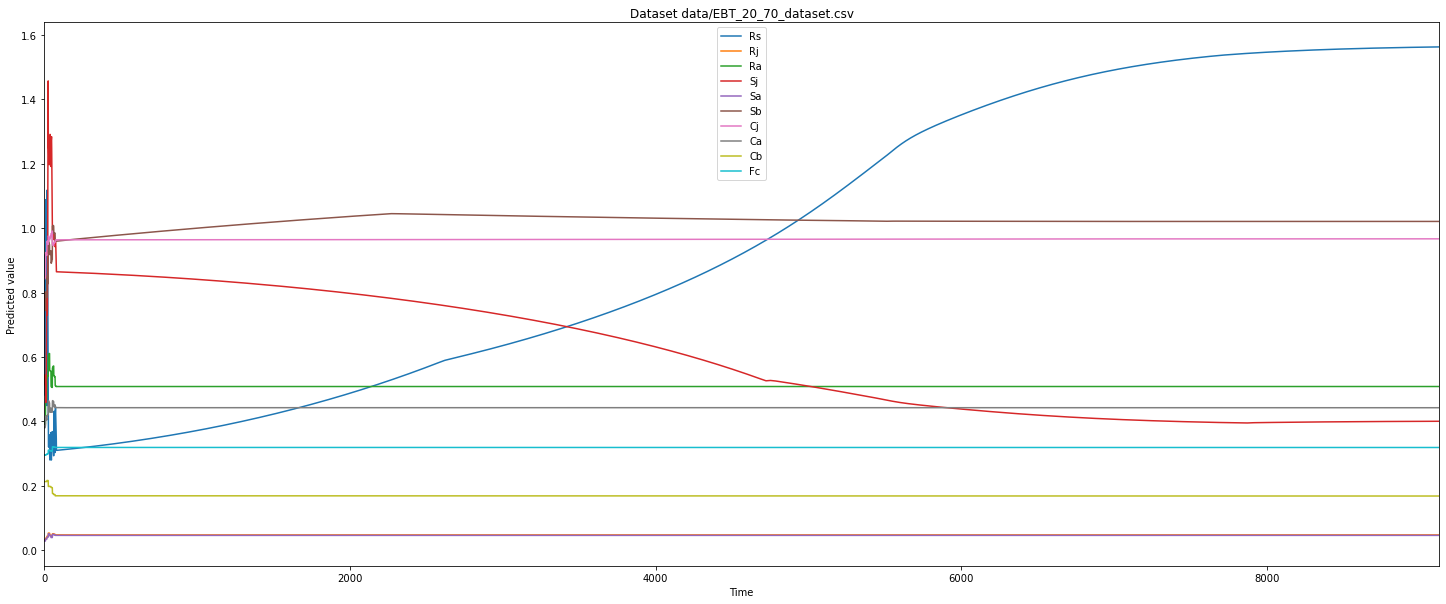

<Figure size 1800x720 with 0 Axes>

In [65]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

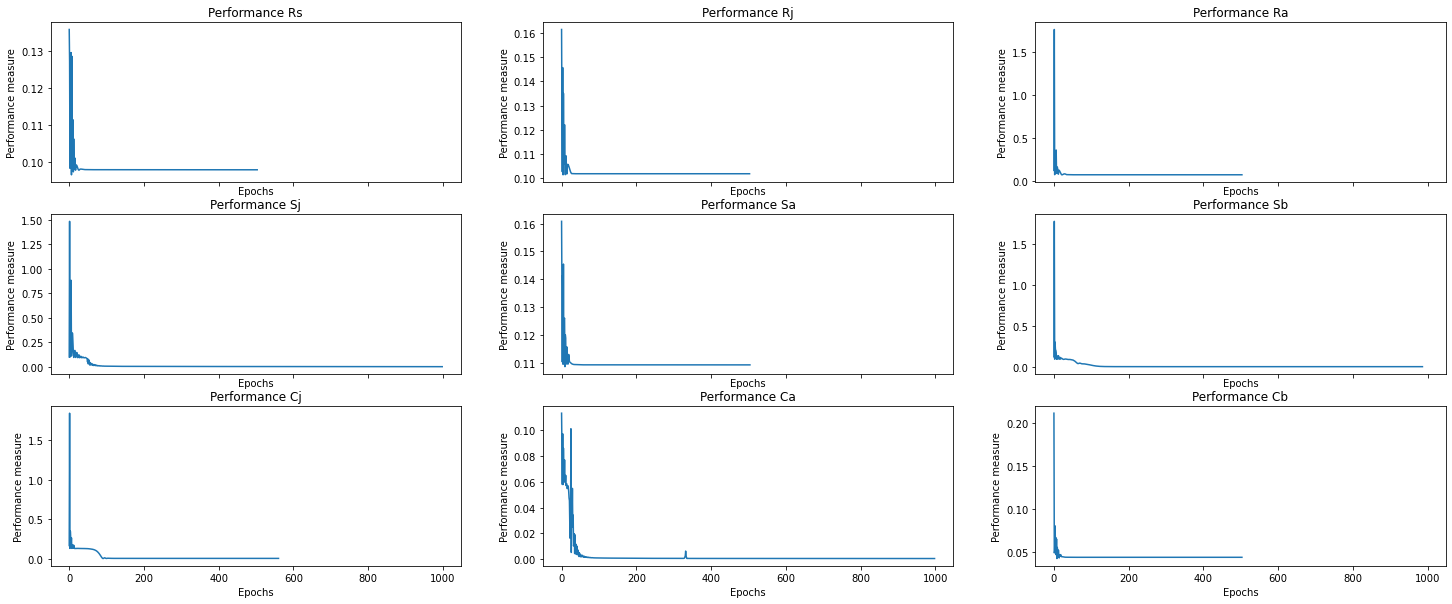

In [63]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

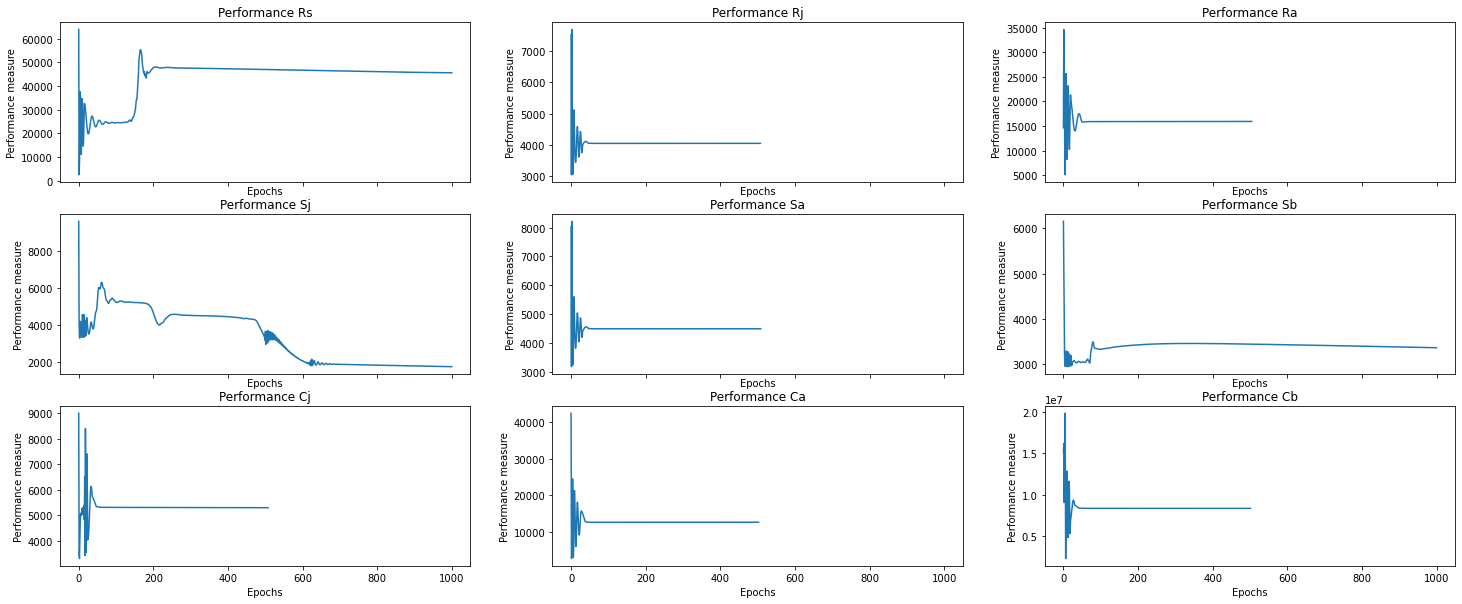

In [66]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=2000, ground_truth={'data/EBT_20_70_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, significance=0.9)

 Dataset:  EBT_20_70_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.107181
Epoch    41: reducing learning rate of group 0 to 1.0000e-02.
Epoch    81: reducing learning rate of group 0 to 1.0000e-03.
Epoch    92: reducing learning rate of group 0 to 1.0000e-04.
Epoch   103: reducing learning rate of group 0 to 1.0000e-05.
Epoch   114: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.003185
Epoch: 500 [25%] 	Loss: 0.003183
INFO: Early stopping at epoch 500
Potential causes:  [4]
Validated causes:  [4]

 Analysis started for target:  Rj
INFO: 

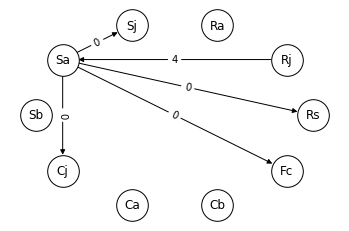

<Figure size 432x288 with 0 Axes>

In [68]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot


Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=2000, ground_truth={'data/EBT_20_70_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=9238, significance=0.9)

 Dataset:  EBT_20_70_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.119256
Epoch    15: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [12%] 	Loss: 0.002226
Epoch: 500 [25%] 	Loss: 0.001573
Epoch   676: reducing learning rate of group 0 to 1.0000e-03.
Epoch   696: reducing learning rate of group 0 to 1.0000e-04.
Epoch   719: reducing learning rate of group 0 to 1.0000e-05.
Epoch   730: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 750 [38%] 	Loss: 0.000921
Epoch: 1000 [50%] 	Loss: 0.000920
INFO: Early stopping at epoch 500
Potential causes:  [

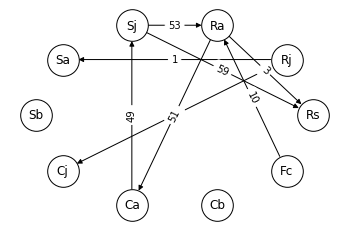

<Figure size 432x288 with 0 Axes>

In [69]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot


Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=2000, ground_truth={'data/EBT_20_70_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=157, significance=0.9)

 Dataset:  EBT_20_70_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.431503
Epoch    17: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [12%] 	Loss: 0.000827
Epoch: 500 [25%] 	Loss: 0.000115
Epoch   552: reducing learning rate of group 0 to 1.0000e-03.
Epoch   572: reducing learning rate of group 0 to 1.0000e-04.
Epoch   583: reducing learning rate of group 0 to 1.0000e-05.
Epoch   605: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 750 [38%] 	Loss: 0.000100
Epoch: 1000 [50%] 	Loss: 0.000100
INFO: Early stopping at epoch 500
Potential causes:  [8

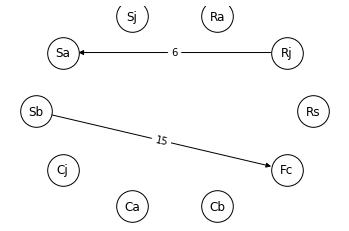

<Figure size 432x288 with 0 Axes>

In [70]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot


Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=2000, ground_truth={'data/EBT_20_70_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=4019, significance=0.9)

 Dataset:  EBT_20_70_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.187672
Epoch   113: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [12%] 	Loss: 0.000119
Epoch: 500 [25%] 	Loss: 0.000106
Epoch: 750 [38%] 	Loss: 0.000092
INFO: Early stopping at epoch 500
Potential causes:  [0, 3]
Validated causes:  [0]

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.166576
Epoch    40: reducing learning rate of group 0 to 1.0000e-02.
Epoch    51: reducing learning rate of group 0 t

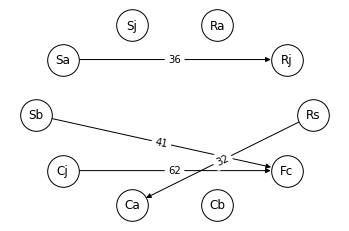

<Figure size 432x288 with 0 Axes>

In [72]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 4019 --plot


Arguments: Namespace(cuda=False, data=['data/EBT_20_70_dataset.csv'], dilation_coefficient=4, early_stopping=True, epochs=2000, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=1000, lr_scheduler=True, optimizer='Adam', plot=True, seed=4019, train_test_split=0.8)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.234597
Epoch    14: reducing learning rate of group 0 to 1.0000e-02.
Epoch    25: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 1000 [50%] 	Loss: 0.000364
Epoch: 2000 [100%] 	Loss: 0.000141

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.021186
Epoch    22: reducing learning rate of group 0 to 1.0000e-02.
Epoch   550: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 1000 [50%] 	Loss: 0.000277
INFO: Early stopping at epoch 500

 Analysis started for target:  Ra
INFO: Initializ

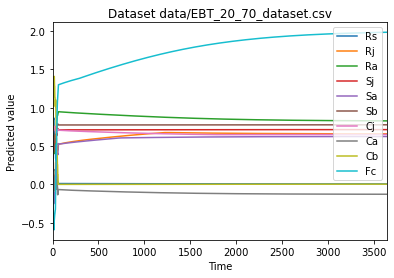

<Figure size 432x288 with 0 Axes>

In [73]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 1000 --dilation_coefficient 4 --kernel_size 4 --seed 4019 --plot

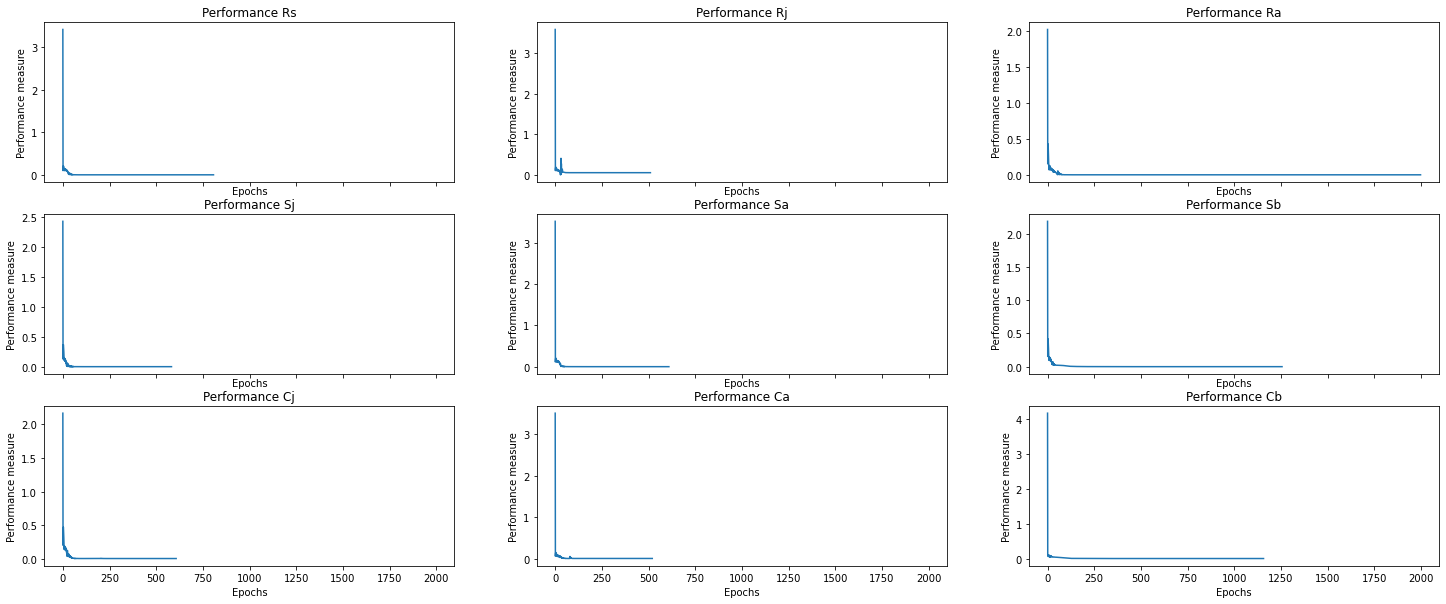

In [74]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

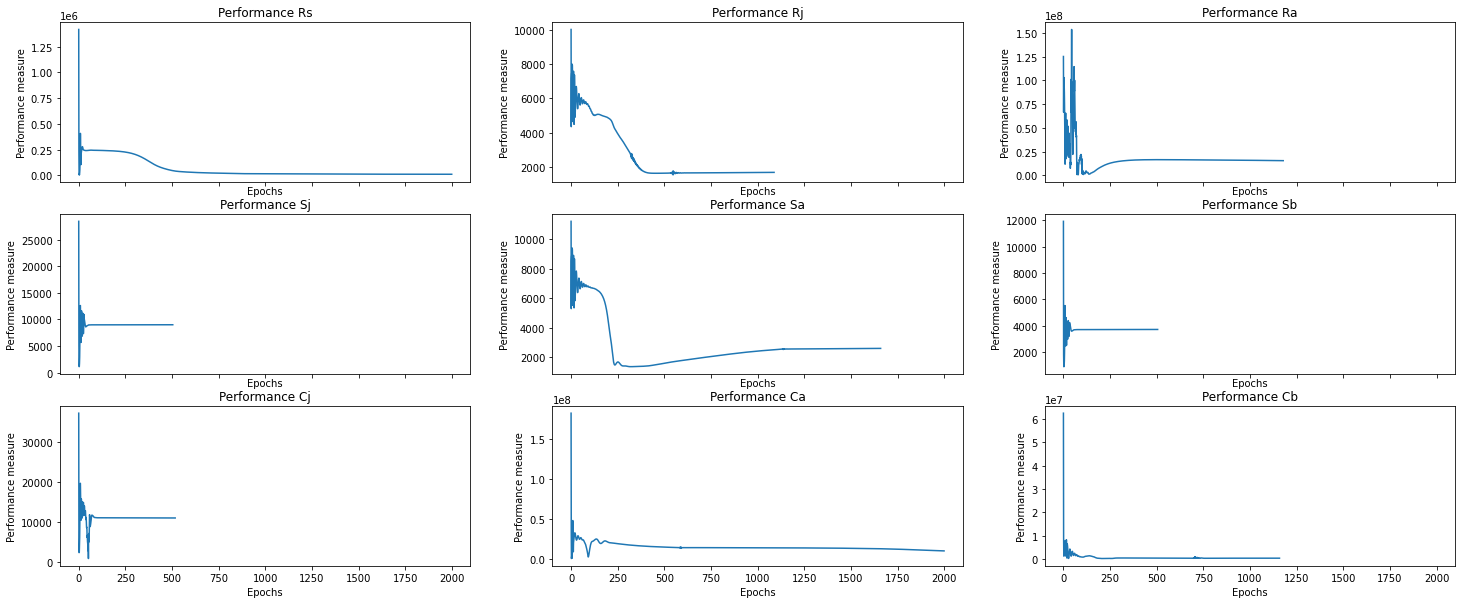

In [75]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-100 years: first run

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 1000 --significance 0.95 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

#### TCDF 0-100 years: second run (1 extra hidden layer, different seed)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 1000 --significance 0.95 --dilation_coefficient 4 --kernel_size 4 --seed 1111 --plot

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

### TCDF with EBT equilibrium dynamics

This data represents the tritrophic biomasses before the introduced fishing pressure on cod. The system first finds it equilibrium and remains stable for ~20 years. Therefore, no relations should be found by the machine learning model.

#### Data cleaning

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML

# Select information of datapoints for each equilibrium state (i.e. between year 0 and 20 & 70 and 100)
first_eq_ebt = ebt[(ebt['Time (year)'] >= 0) & (ebt['Time (year)'] <= 20)]
second_eq_ebt = ebt[(ebt['Time (year)'] >= 70) & (ebt['Time (year)'] <= 100)]

# Normalize data with min-max normalization
scaler = MinMaxScaler()
ebt_scaled_1 = scaler.fit_transform(first_eq_ebt[['Rs', 'Rj', 'Ra',
                                                  'Sj', 'Sa', 'Sb',
                                                  'Cj', 'Ca', 'Cb',
                                                  'Fc']])
ebt_scaled_2 = scaler.fit_transform(second_eq_ebt[['Rs', 'Rj', 'Ra',
                                                   'Sj', 'Sa', 'Sb',
                                                   'Cj', 'Ca', 'Cb',
                                                   'Fc']])

# Write scaled data to DataFrame
labels = ['Rs', 'Rj', 'Ra',
          'Sj', 'Sa', 'Sb',
          'Cj', 'Ca', 'Cb',
          'Fc']
ebt_scaled_1 = pd.DataFrame(ebt_scaled_1, columns = labels)
ebt_scaled_2 = pd.DataFrame(ebt_scaled_2, columns = labels)

# Check the scaled DataFrame
display(ebt_scaled_1.head(-10))
display(ebt_scaled_2.head(-10))

In [ ]:
# Visualize scaled data first equilibrium
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as lines

visualise_scaled(ebt_scaled_1, [0,20])

In [ ]:
# Visualize scaled data second equilibrium
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as lines

visualise_scaled(ebt_scaled_2, [70,100])

In [ ]:
# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_first_eq_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_scaled_1.to_csv(EBTScaled_path, index = False)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_second_eq_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_scaled_2.to_csv(EBTScaled_path, index = False)

#### TCDF first equilibrium: first run 

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_first_eq_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 4000 --log_interval 1000 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_first_eq_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 4000 --log_interval 1000 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF first equilibrium: second run (different seed)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_first_eq_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 4000 --log_interval 1000 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 1111 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_first_eq_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 4000 --log_interval 1000 --dilation_coefficient 4 --kernel_size 4 --seed 1111 --plot

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF second equilibrium: first run 

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_second_eq_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 4000 --log_interval 1000 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_second_eq_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 4000 --log_interval 1000 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF second equilibrium: second run (different seed)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_second_eq_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 4000 --log_interval 1000 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 1238 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_second_eq_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 4000 --log_interval 1000 --dilation_coefficient 4 --kernel_size 4 --seed 1238 --plot

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

### TCDF with EBT transient dynamics

This data represents the tritrophic biomasses during the introduced fishing pressure on cod. At 20 years Fc increases and is put to a halt on 40 years. Therefore I split the transient dynamics into two separate transient phases: 20-40 years (fishing pressure increases linearly) and 40-70 years (searching for a new equilibrium).

#### Data cleaning

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML

# Select information of datapoints for each transient state (i.e. between year 20 and 60 & 60 and 70)
first_trans_ebt = ebt[(ebt['Time (year)'] >= 20) & (ebt['Time (year)'] <= 60)]
second_trans_ebt = ebt[(ebt['Time (year)'] >= 60) & (ebt['Time (year)'] <= 70)]

# Normalize data with min-max normalization
scaler = MinMaxScaler()
ebt_scaled_1 = scaler.fit_transform(first_trans_ebt[['Rs', 'Rj', 'Ra',
                                                  'Sj', 'Sa', 'Sb',
                                                  'Cj', 'Ca', 'Cb',
                                                  'Fc']])
ebt_scaled_2 = scaler.fit_transform(second_trans_ebt[['Rs', 'Rj', 'Ra',
                                                   'Sj', 'Sa', 'Sb',
                                                   'Cj', 'Ca', 'Cb',
                                                   'Fc']])

# Write scaled data to DataFrame
labels = ['Rs', 'Rj', 'Ra',
          'Sj', 'Sa', 'Sb',
          'Cj', 'Ca', 'Cb',
          'Fc']
ebt_scaled_1 = pd.DataFrame(ebt_scaled_1, columns = labels)
ebt_scaled_2 = pd.DataFrame(ebt_scaled_2, columns = labels)

# Check the scaled DataFrame
display(ebt_scaled_1.head(-10))
display(ebt_scaled_2.head(-10))

In [ ]:
# Visualize scaled data first transient
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as lines

visualise_scaled(ebt_scaled_1, [20,60])

In [ ]:
# Visualize scaled data second transient
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as lines

visualise_scaled(ebt_scaled_2, [60,70])

In [ ]:
# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_first_trans_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_scaled_1.to_csv(EBTScaled_path, index = False)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_second_trans_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_scaled_2.to_csv(EBTScaled_path, index = False)

#### TCDF first transient: first run 

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_first_trans_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 5000 --log_interval 1000 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 24310 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_first_trans_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 5000 --log_interval 1000 --dilation_coefficient 4 --kernel_size 4 --seed 24310 --plot

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF first transient: second run (1 less hidden layer)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_first_trans_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 5000 --log_interval 1000 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 24310 --plot

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

#### TCDF first transient: third run (1 more hidden layer, different seed)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_first_trans_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 5000 --log_interval 1000 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 568943 --plot

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

#### TCDF second transient: first run 

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_second_trans_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 5000 --log_interval 1000 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_second_trans_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 5000 --log_interval 1000 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF second transient: second run (1 less hidden layer)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_second_trans_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 5000 --log_interval 1000 --significance 0.95 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_second_trans_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 5000 --log_interval 1000 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

## Adding white noise (Additive White Gaussian Noise)

Training the model with additive noise might be helpful in avoiding overfitting of the model. Data in this section is augmented by adding noise with additive white Gaussian noise.

In [ ]:
# Adding noise using target SNR

# Set a target SNR
target_snr = 0.001
# Calculate signal power and convert to dB 
average_ca = np.mean(ebt['Ca'])

# Calculate noise according to [2] then convert to watts
noise = abs(average_ca - target_snr)

# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise), len(ebt['Ca']))
# Noise up the original signal
ca_noise = ebt['Ca'] + noise_volts

plt.plot(np.arange(len(ca_noise)), ca_noise)
plt.plot(np.arange(len(ebt['Ca'])), ebt['Ca'])
ca_noise

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML

# Select information of datapoints 
total_ebt = ebt[(ebt['Time (year)'] >= 0) & (ebt['Time (year)'] <= 100)]


# Normalize data with min-max normalization
scaler = MinMaxScaler()
ebt_scaled = scaler.fit_transform(total_ebt[['Rs', 'Rj', 'Ra',
                                             'Sj', 'Sa', 'Sb',
                                             'Cj', 'Ca', 'Cb',
                                             'Fc']])


# Write scaled data to DataFrame
labels = ['Rs', 'Rj', 'Ra',
          'Sj', 'Sa', 'Sb',
          'Cj', 'Ca', 'Cb',
          'Fc']
ebt_scaled = pd.DataFrame(ebt_scaled, columns = labels)

# Check the scaled DataFrame
display(ebt_scaled.head(-10))

In [ ]:
# Adding noise using target SNR

# Set a target SNR
target_snr = 1e-1000
# Calculate signal power and convert to dB 
average_ca = np.mean(ebt_scaled['Cj'])

# Calculate noise according to [2] then convert to watts
noise = abs(average_ca - target_snr)

# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise), len(ebt_scaled['Cj']))
# Noise up the original signal
ca_noise = ebt_scaled['Cj'] + noise_volts

plt.plot(np.arange(len(ca_noise)), ca_noise)
plt.plot(np.arange(len(ebt_scaled['Cj'])), ebt_scaled['Cj'])
ca_noise